# Minority Rule Simulation

This notebook explains the methodology behind a simulation of the effects of the minority rule on personal payments adoption and displays the results. For more background, see [this post](https://agost.blog/2019/06/mapping-crypto-minority-rule/). The code is available on [Github](https://github.com/abiro/minority_sim).

## Setup

We assume a population of $N_{\text{pop}}$ individuals and a personal payment solution, Zebra with total adoption in the population. There exists a uniformly distributed subset of the population that is strongly dissatisfied with Zebra due to privacy concerns. The probability that an individual belongs to the dissatisfied subset is $P_{\text{inflex}}$. We assume that each individual belongs to a maximum number of $N_{\text{groups}}$ social groups where members use the same payment protocol to transact directly with each other. Following [\[Galam 2002\]](https://link.springer.com/article/10.1140/epjb/e20020045), a probability distribution for group sizes $\{a_i\}$ is assumed that satisfies the constraint

$$
\begin{equation*}
\sum_{i=1}^L {a_i} = 1
\end{equation*}
$$

where $i =1 ,2,...,L$ stand for group sizes and $L$ is the largest group size.

## Simulation

A new personal payment solution, Alpha, is introduced with provable privacy that builds on a new protocol. Members of the dissatisfied population immediately adopt the new solution resulting in an initial user base of $N_{\text{inflex}} = N_{\text{pop}} \cdot P_{\text{inflex}}$ individuals. After the introduction Alpha, inflexible individuals refuse to send or receive payments over Zebra, and start advocating the use of Alpha and the power of intransigence in their respective social groups. **We'd like to know if this strategy can lead to the adoption of Alpha by a majority of the entire population and if so in what time.**

We randomly assign all individuals to $N_{\text{groups}}$ social groups of varying sizes. We sample the group sizes from a preassumed group size distribution. We select $N_{\text{inflex}}$ individuals at random who form the initial inflexible population. We model the passing of time in time steps $t$ where each step corresponds to one month. We assume that the advocacy of the inflexible population grows their number by a constant factor of $G_{\text{inflex}}$ at each timestep. We model the probability that a group adopts the Alpha protocol as

$$
P_{\text{adopt}}(i, s, a) = 
     \begin{cases}
       \frac{1}{s-a+1}, &\quad\text{if }i>0\text{ and}\\
       0 &\quad\text{otherwise,} \\
     \end{cases}
$$

where $i$ is the number of inflexible individuals in the group, $s$ is the group size, $a$ is the number of individuals already using the Alpha protocol and $i \leq a$. When a group is converted, all of its members become users of the Alpha protocol, thus increasing the probability of adoption in other groups. At each time step, we calculate the probability of adoption for each group, decide whether they adopted based on random sampling, update members if they adopted and finally grow the inflexible population based on the preset growth factor (the selection of new inflexibles is random). We repeat this process until a majority of the entire population has either adopted Alpha or a maximum number of time steps is reached.

## Parameters

We ran simulations with three different parameter configurations. The values are displayed in the table below. Only $P_{\text{inflex}}$ was varied between configurations. The parameter values are based on estimates instead of research to the author's regret due to the exploratory nature of this experiment. 

A maximum group size $L$ of 6 was chosen as that assumes 15 direct connections in a group. Beyond that, the quadratic growth of connections is assumed prohibitive for direct transactions. A non-zero probability for a group size of 1 means that not all individuals may be part of $N_{\text{groups}}$ social groups. It was assumed that direct payments in groups of 2 are most frequent, and no assumption was made about the relative frequencies of larger group sizes. The maximum number of social groups, $N_{\text{groups}}$, was set to 3 reflecting the three social spheres of family, friends and work. Limiting the maximum number of social groups to 3 per individual is probably a conservative assumption.

The growth factor of the inflexible population, $G_{\text{inflex}}$, was set to 1.05. This means that 1 in 20 inflexible individuals are expected to convert 1 additional member to their cause from the rest of the population each month. This is probably also a conservative assumption.

The simulation was repeated 16 times with each configuration. 

In [1]:
%matplotlib notebook

from pathlib import Path

import ipy_table

from data_helpers import *


DATA_DIR = './data'

simulation_paths = list(Path(DATA_DIR).iterdir())

config_table = get_config_table(simulation_paths)
ipy_table.make_table(config_table)
ipy_table.apply_theme('basic')
ipy_table.set_global_style(float_format='%0.3f')
ipy_table.set_row_style(7, bold=True)

sim_name,p_inflexible_001,p_inflexible_0025,p_inflexible_005
group_dist,"[0.1, 0.3, 0.15, 0.15, 0.15, 0.15]","[0.1, 0.3, 0.15, 0.15, 0.15, 0.15]","[0.1, 0.3, 0.15, 0.15, 0.15, 0.15]"
inflex_growth,1.050,1.050,1.050
max_t,120,120,120
n_groups,3,3,3
n_pop,1000000,1000000,1000000
n_sim,16,16,16
p_inflex,0.010,0.025,0.050
target_p_app,0.500,0.500,0.500


## Results

It turns out that the inflexible strategy is successful given the above assumptions even for $P_{\text{inflex}} = 0.01$, when a majority adoption of Alpha is reached in 42 months in the entire population. For $P_{\text{inflex}} = 0.025$, 24 months are enough. For $P_{\text{inflex}} = 0.05$, 11 months are enough. 

All 16 simulations with a parameter configuration yielded the same results as apparent from the descriptive statistics of the steps taken across the simulations. Finally, we plot the adoption of Alpha in the entire population against time steps taken with the different configurations.

In [2]:
aggregates = {sp.name: get_aggregate_df(sp) for sp in simulation_paths}

In [3]:
aggregates['p_inflexible_001']['steps'].describe()

count    16.0
mean     42.0
std       0.0
min      42.0
25%      42.0
50%      42.0
75%      42.0
max      42.0
Name: steps, dtype: float64

In [4]:
aggregates['p_inflexible_0025']['steps'].describe()

count    16.0
mean     24.0
std       0.0
min      24.0
25%      24.0
50%      24.0
75%      24.0
max      24.0
Name: steps, dtype: float64

In [5]:
aggregates['p_inflexible_005']['steps'].describe()

count    16.0
mean     11.0
std       0.0
min      11.0
25%      11.0
50%      11.0
75%      11.0
max      11.0
Name: steps, dtype: float64

<IPython.core.display.Javascript object>


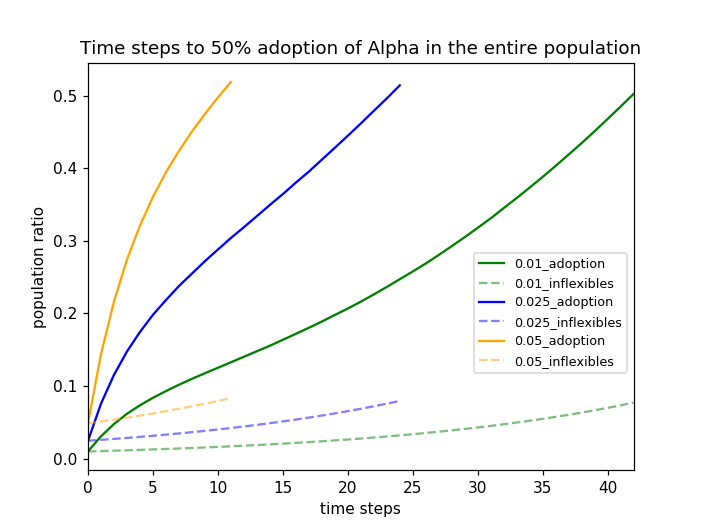

In [6]:
import re


from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

simulations = {sp.name: get_simulation_df(sp, 'sim_0') for sp in simulation_paths}

ax = plt.gca()
ax.set_title('Time steps to 50% adoption of Alpha in the entire population')
ax.set_xlabel('time steps')
ax.set_ylabel('population ratio')

colors = ['green', 'blue', 'orange']
for i, df in enumerate(simulations.values()):
    ax = df['p_app'].plot(ax=ax, color=colors[i])
    ax = df['p_inflex'].plot(ax=ax, color=colors[i], linestyle='dashed', alpha=0.5)

font_p = FontProperties()
font_p.set_size('small')
legend = []
for k in simulations:
    name = re.sub('\D', '', k)
    name = name[:1] + '.' + name[1:]
    legend.append(name + '_adoption')
    legend.append(name + '_inflexibles')

ax.legend(legend, prop=font_p, bbox_to_anchor=(1, 0.55))

ax

Continuous lines represent the adoption of Alpha as a ratio of the entire population. Dashed lines represent the ratio of inflexible individuals in the entire population. The number prefix in the legend is the initial ratio of inflexibles in the population.

## Literature

Galam, Serge. "Minority opinion spreading in random geometry." The European Physical Journal B-Condensed Matter and Complex Systems 25.4 (2002): 403-406.

Galam, Serge, and Frans Jacobs. "The role of inflexible minorities in the breaking of democratic opinion dynamics." Physica A: Statistical Mechanics and its Applications 381 (2007): 366-376.

Taleb, Nassim Nicholas. "The Most Intolerant Wins: The Dominance of the Stubborn Minority." *Skin in the game: Hidden asymmetries in daily life.* Random House, 2018.